In [17]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import signal

from processing_helpers import get_energy
from processing_helpers import get_con_energy
from processing_helpers import get_residuals


In [18]:
joule_to_uWh = 0.000277777778*1000*1000

In [19]:
coap_256_nb    = pd.read_csv("../measurements/otii/model_test_coap_256_nb.csv"   , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_256_ltem  = pd.read_csv("../measurements/otii/model_test_coap_256_ltem.csv" , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_1280_nb   = pd.read_csv("../measurements/otii/model_test_coap_1280_nb.csv"  , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_1280_ltem = pd.read_csv("../measurements/otii/model_test_coap_1280_ltem.csv", usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh

mqtt_256_nb    = pd.read_csv("../measurements/otii/model_test_mqtt_256_nb.csv"   , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_256_ltem  = pd.read_csv("../measurements/otii/model_test_mqtt_256_ltem.csv" , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_4096_nb   = pd.read_csv("../measurements/otii/model_test_mqtt_4096_nb.csv"  , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_4096_ltem = pd.read_csv("../measurements/otii/model_test_mqtt_4096_ltem.csv", usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh

In [20]:
regression_results = pd.read_csv("reg_res.csv")

timing_coap_nb = regression_results["timing_coap_nb"].to_numpy()
energy_coap_nb = regression_results["energy_coap_nb"].to_numpy()
timing_coap_ltem = regression_results["timing_coap_ltem"].to_numpy()
energy_coap_ltem = regression_results["energy_coap_ltem"].to_numpy()
timing_mqtt_nb = regression_results["timing_mqtt_nb"].to_numpy()
energy_mqtt_nb = regression_results["energy_mqtt_nb"].to_numpy()
timing_mqtt_ltem = regression_results["timing_mqtt_ltem"].to_numpy()
energy_mqtt_ltem = regression_results["energy_mqtt_ltem"].to_numpy()


In [21]:
V = 3.7

f_micro = 1/(1000*1000)
hour = 3600

sample_pagings_act = [2.49, 2.50, 2.48, 2.45,2.50]
sample_pagings_con = [2.39, 2.33, 2.83, 2.36, 2.84, 2.42, 2.34, 2.82, 2.38]
print(np.mean(sample_pagings_con))

sample_con_end = [7.32, 8.25, 7.54, 8.03, 7.61]

2.523333333333333


In [22]:
#device parameters
p_idle = 155*V #W
p_sleep = 108*V #W


In [23]:
start_mqtt_nb   = [37,137] #[time,energy]
start_mqtt_ltem = [20,265]
start_coap_nb   = [33,110]
start_coap_ltem = [15,201]



In [24]:
## Con_energy : (cDRX timeout, paging interval, paging energy, disconnect energy)

#NB-IoT
E_cdrx_nb = get_con_energy(20.48, 2.048, 2.50, 1.93, p_idle)

#LTE-M
E_cdrx_ltem = get_con_energy(10.24, 0.320, 3.15, 0.376, p_idle)

E_cdrx_ltem_short = get_con_energy(3.84, 0.320, 3.15, 0.376, p_idle)

#Active state variables
t_active = 30 #s
t_act_interval = 2.56 #s

e_act_paging = 2.50 * f_micro #uWh
e_act_end = 0.252 * f_micro
e_act_init_paging = 1.52 * f_micro #uWh




In [25]:
print(E_cdrx_nb)
print(E_cdrx_ltem)
print(E_cdrx_ltem_short)

start_coap_ltem_short = [start_coap_ltem[0]-(10.24-3.84), start_coap_ltem[1]-E_cdrx_ltem+E_cdrx_ltem_short]

30.192577777777775
102.80728888888889
38.78773333333333


In [26]:
class Test:
    def __init__(self, data, T_msg, n_bytes, t, E, E_start, cdrx):
        self.data = data
        self.duration = np.linspace(0,len(data)*0.00025,len(data))    
        self.T_msg = T_msg
        self.n_bytes = n_bytes
        self.t = t
        self.E = E
        self.E_start = E_start
        self.cdrx = cdrx

coap_test_array = []
coap_test_array.append(Test(coap_256_nb,    300,256, timing_coap_nb,   energy_coap_nb, start_coap_nb, E_cdrx_nb))
coap_test_array.append(Test(coap_256_ltem,  300,256, timing_coap_ltem, energy_coap_ltem, start_coap_ltem, E_cdrx_ltem))
coap_test_array.append(Test(coap_1280_nb,   300,1280,timing_coap_nb,   energy_coap_nb, start_coap_nb, E_cdrx_nb))
coap_test_array.append(Test(coap_1280_ltem, 300,1280,timing_coap_ltem, energy_coap_ltem, start_coap_ltem, E_cdrx_ltem))

coap_test_array.append(Test(coap_256_ltem,  300,256, timing_coap_ltem, energy_coap_ltem, start_coap_ltem_short, E_cdrx_ltem_short))
coap_test_array.append(Test(coap_1280_ltem, 300,1280,timing_coap_ltem, energy_coap_ltem, start_coap_ltem_short, E_cdrx_ltem_short))


mqtt_test_array = []
mqtt_test_array.append(Test(mqtt_256_nb,    300,256,  timing_mqtt_nb,   energy_mqtt_nb,   start_mqtt_nb, E_cdrx_nb))
mqtt_test_array.append(Test(mqtt_256_ltem,  300,256,  timing_mqtt_ltem, energy_mqtt_ltem, start_mqtt_ltem, E_cdrx_ltem))
mqtt_test_array.append(Test(mqtt_4096_nb,   300,4096, timing_mqtt_nb,   energy_mqtt_nb,   start_mqtt_nb, E_cdrx_nb))
mqtt_test_array.append(Test(mqtt_4096_ltem, 300,4096, timing_mqtt_ltem, energy_mqtt_ltem, start_mqtt_ltem, E_cdrx_ltem))


In [27]:
coap_predictions = []

for i in coap_test_array:
    coap_predictions.append( 
        get_energy(
            n_bytes = i.n_bytes, 
            max_bytes = 1439, 
            T_msg = i.T_msg,
            E_cdrx = i.cdrx,
            p_sleep = p_sleep,
            reg_coeffs_t = i.t,
            reg_coeffs_e = i.E,
            start_params = i.E_start,
            endpoint = len(i.data)*0.00025
        )
    )

mqtt_predictions = []
for i in mqtt_test_array:
    mqtt_predictions.append( 
        get_energy(
            n_bytes = i.n_bytes, 
            max_bytes = 4096, 
            T_msg = i.T_msg,
            E_cdrx = i.cdrx,
            p_sleep = p_sleep,
            reg_coeffs_t = i.t,
            reg_coeffs_e = i.E,
            start_params = i.E_start,
            endpoint = len(i.data)*0.00025
        )
    )

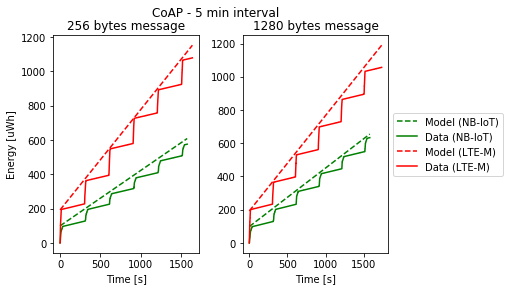

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.3)

fig.suptitle("CoAP - 5 min interval")

ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")

ax1.set_title("256 bytes message")
ax2.set_title("1280 bytes message")


ax1.plot(coap_test_array[0].duration, coap_predictions[0],     "g--", label = "Model (NB-IoT)")
ax1.plot(coap_test_array[0].duration, coap_test_array[0].data, "g",   label = "Data (NB-IoT)" )
ax1.plot(coap_test_array[1].duration, coap_predictions[1],     "r--", label = "Model (LTE-M)")
ax1.plot(coap_test_array[1].duration, coap_test_array[1].data, "r",   label = "Data (LTE-M)" )

ax2.plot(coap_test_array[2].duration, coap_predictions[2],      "g--",label = "Model (NB-IoT)")
ax2.plot(coap_test_array[2].duration, coap_test_array[2].data,  "g",  label = "Data (NB-IoT)" )
ax2.plot(coap_test_array[3].duration, coap_predictions[3] ,     "r--",label = "Model (LTE-M)")
ax2.plot(coap_test_array[3].duration, coap_test_array[3].data , "r",  label = "Data (LTE-M)" )

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


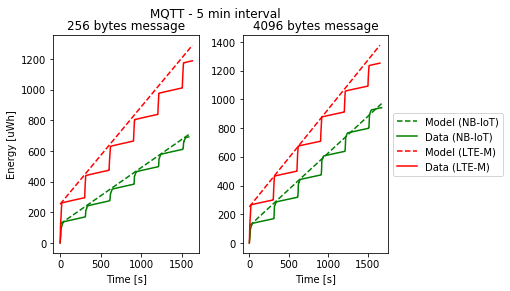

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2)

plt.subplots_adjust(wspace = 0.3)

fig.suptitle("MQTT - 5 min interval")

ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")

ax1.set_title("256 bytes message")
ax2.set_title("4096 bytes message")

ax1.plot(mqtt_test_array[0].duration, mqtt_predictions[0],     "g--", label = "Model (NB-IoT)")
ax1.plot(mqtt_test_array[0].duration, mqtt_test_array[0].data, "g",   label = "Data (NB-IoT)" )
ax1.plot(mqtt_test_array[1].duration, mqtt_predictions[1],     "r--", label = "Model (LTE-M)")
ax1.plot(mqtt_test_array[1].duration, mqtt_test_array[1].data, "r",   label = "Data (LTE-M)" )

ax2.plot(mqtt_test_array[2].duration, mqtt_predictions[2],      "g--",label = "Model (NB-IoT)")
ax2.plot(mqtt_test_array[2].duration, mqtt_test_array[2].data,  "g",  label = "Data (NB-IoT)" )
ax2.plot(mqtt_test_array[3].duration, mqtt_predictions[3] ,     "r--",label = "Model (LTE-M)")
ax2.plot(mqtt_test_array[3].duration, mqtt_test_array[3].data , "r",  label = "Data (LTE-M)" )

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

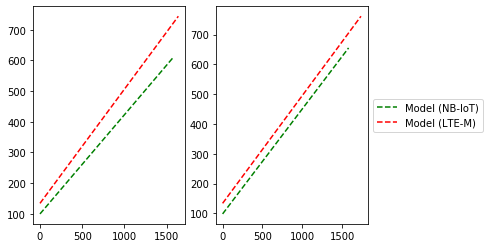

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(coap_test_array[0].duration, coap_predictions[0],     "g--", label = "Model (NB-IoT)")
ax1.plot(coap_test_array[1].duration, coap_predictions[4],     "r--", label = "Model (LTE-M)")

ax2.plot(coap_test_array[2].duration, coap_predictions[2],     "g--", label = "Model (NB-IoT)")
ax2.plot(coap_test_array[3].duration, coap_predictions[5],     "r--", label = "Model (LTE-M)")

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

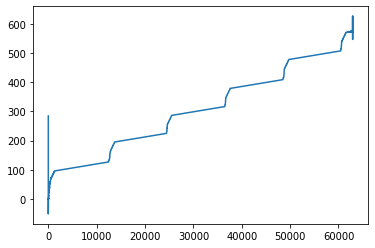

In [34]:
plt.plot(signal.resample(coap_test_array[0].data, 629300))